# Investigating the correlation between disease composition at taxonomically-related species

### Import modules

In [1]:
from collections import defaultdict
from itertools import combinations
import random

import logging
import pandas as pd
from tqdm import tqdm
    
# Stats
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from statannot import add_stat_annotation
import numpy as np
from scipy.stats import sem

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

In [2]:
%matplotlib inline

In [3]:
logging.disable()
pd.options.mode.chained_assignment = None

In [4]:
DATA_DIR = '../data/processed'

### Load plant-disease evidences

In [5]:
collapsed_plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_collapsed.tsv.gz',
    compression='gzip',
    sep='\t',
    low_memory=False
)

In [6]:
literature_data = collapsed_plant_disease_df[
    collapsed_plant_disease_df['database'] == 'bern2'
]

plant_lit_ids = set(literature_data['plant_curie'].to_list())

literature_data.shape, len(plant_lit_ids)

((129539, 5), 4413)

In [7]:
database_data = collapsed_plant_disease_df[
    collapsed_plant_disease_df['database'] != 'bern2'
]

plant_db_ids = set(database_data['plant_curie'].to_list())

database_data.shape, len(plant_db_ids)

((43163, 5), 2338)

In [8]:
# Total plant count
len(plant_lit_ids.union(plant_db_ids))

5636

### Get genus mapping for plants

In [9]:
genus_to_species_lit, family_to_species_lit = get_genus_and_family_info_for_plants(plant_lit_ids)

order genus: 100%|████████████████████████████████████████████████████████████████████| 16768/16768 [00:00<00:00, 32259.05it/s]


In [10]:
genus_to_species_db, family_to_species_db = get_genus_and_family_info_for_plants(plant_db_ids)

order genus: 100%|████████████████████████████████████████████████████████████████████| 16768/16768 [00:00<00:00, 31056.35it/s]


In [11]:
disease_vector = list(set(collapsed_plant_disease_df['disease_curie'].to_list()))
len(disease_vector)

23

### Prepare plant-disease dicts

In [12]:
def get_non_binary_dict(df:pd.DataFrame):
    """Get plant-disease data dictionary based on citation counts"""
    
    non_binary_dict = {}
        
    for plant_curie, disease_curie, evidence in tqdm(
        df[['plant_curie', 'disease_curie', 'evidence']].values
    ):
        pmid = evidence.split('_')[0]

        if plant_curie not in non_binary_dict:
            non_binary_dict[plant_curie] = defaultdict(set)

        non_binary_dict[plant_curie][disease_curie].add(pmid)
    return non_binary_dict

In [13]:
disease_literature_non_binary_dict = get_non_binary_dict(literature_data)

100%|██████████████████████████████████████████████████████████████████████████████| 129539/129539 [00:00<00:00, 618384.18it/s]


In [14]:
disease_db_non_binary_dict = get_non_binary_dict(database_data)

100%|████████████████████████████████████████████████████████████████████████████████| 43163/43163 [00:00<00:00, 630733.28it/s]


### Calculate chemical similarity for plants in the same genus or family

In [19]:
def calculate_similarity(plant_1, plant_2, species_to_vectors):
    """Calculate pearson coeffiencient/cosine similarity."""
    diseases_plant_1_dict = species_to_vectors[plant_1]
    diseases_plant_2_dict = species_to_vectors[plant_2]
    
    elements_in_plant_1 = []
    elements_in_plant_2 = []
    
    for disease in disease_vector:
        if disease in diseases_plant_1_dict:
            elements_in_plant_1.append(len(diseases_plant_1_dict[disease]))
        else:
            elements_in_plant_1.append(0)
            
        if disease in diseases_plant_2_dict:
            elements_in_plant_2.append(len(diseases_plant_2_dict[disease]))
        else:
            elements_in_plant_2.append(0)
    try:
        corr = (
            pearsonr(elements_in_plant_1, elements_in_plant_2)[0],
            1 - cosine(elements_in_plant_1, elements_in_plant_2),
        )
    except:
        corr = None, None
    
    return corr


def calculate_overlap_for_taxa_level(
    taxonomy_dict,
    species_to_disease_dict,
    pair_type,
):
    similarity_list = []
    skipped = 0
    correlation_errors = 0
    
    for _, species in tqdm(
        taxonomy_dict.items(),
        desc='calculating similarity...',
        total=len(taxonomy_dict),
    ):
        # Not enough species to calculate similarity
        if len(species) <= 1:
            skipped += 1
            continue
                        
        for plant_1, plant_2 in combinations(species, 2):
            
            if (
                plant_1 not in species_to_disease_dict or 
                plant_2 not in species_to_disease_dict
            ):
                continue
            
            # pearson coefficient
            corr_coeff, cosine = calculate_similarity(
                plant_1, plant_2, species_to_disease_dict
            )
            
            if not corr_coeff:
                correlation_errors += 1
                continue
            
            similarity_list.append({
                'plant_1': plant_1,
                'plant_2': plant_2,
                'pair_type': pair_type,
                'pearson_coefficient': corr_coeff,
                'cosine_sim': cosine,
            })    
            
    return pd.DataFrame(similarity_list), correlation_errors

In [20]:
lit_genus_similarity, skipped_genus_lit = calculate_overlap_for_taxa_level(
    taxonomy_dict=genus_to_species_lit, # genus to species
    species_to_disease_dict=disease_literature_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same genus',
)

lit_family_similarity, skipped_fam_lit = calculate_overlap_for_taxa_level(
    taxonomy_dict=family_to_species_lit, # family to species
    species_to_disease_dict=disease_literature_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same family',
)

calculating similarity...: 100%|█████████████████████████████████████████████████████████████| 339/339 [00:23<00:00, 14.46it/s]


In [21]:
db_genus_similarity, skipped_fam_db = calculate_overlap_for_taxa_level(
    taxonomy_dict=genus_to_species_db, # genus to species
    species_to_disease_dict=disease_db_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same genus',
)

db_family_similarity, skipped_fam_db = calculate_overlap_for_taxa_level(
    taxonomy_dict=family_to_species_db, # family to species
    species_to_disease_dict=disease_db_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same family',
)

calculating similarity...: 100%|█████████████████████████████████████████████████████████████| 226/226 [00:10<00:00, 22.59it/s]


### Calculate disease similarity for non taxonomically related plants

In [22]:
def calculate_baseline_overlap(
    all_plants,
    family_taxonomy,
    species_to_disease_dict,
):
    """Calculate overlap (disease/chemical) for plants ensuring that they are not belonging 
    to the same family (taxonomically-related)."""
    
    # List to store the similarity/overlap for these non-taxonomically plants
    similarity_list = []
        
    species_to_family = {
        plant: family
        for family, species in family_taxonomy.items()
        for plant in species
    }
    
    outdated_ids = set()
    
    # Ensure it is a list
    all_plants = list(all_plants)
    
    while len(similarity_list) < 100000:
        # Get two random plants
        plant_1, plant_2 = random.choices(all_plants, k=2)
        
        # Plants with a wrong identifier
        if plant_1 not in species_to_family:
            outdated_ids.add(plant_1)
            continue
            
        if plant_2 not in species_to_family:
            outdated_ids.add(plant_2)
            continue
                
        # Skip if the plants belong to the same family
        if species_to_family[plant_1] == species_to_family[plant_2]:
            continue  
        
        # pearson coefficient
        corr_coeff, cosine = calculate_similarity(
            plant_1, plant_2, species_to_disease_dict
        )
        
        if not corr_coeff:
            continue

        similarity_list.append({
            'plant_1': plant_1,
            'plant_2': plant_2,
            'pair_type': 'Random',
            'pearson_coefficient': corr_coeff,
            'cosine_sim': cosine,
        })
            
    return pd.DataFrame(similarity_list), outdated_ids

In [23]:
lit_baseline_similarity, lit_outdated_ids = calculate_baseline_overlap(
    all_plants=plant_lit_ids,
    family_taxonomy=family_to_species_lit,  # family to species
    species_to_disease_dict=disease_literature_non_binary_dict,
)

In [24]:
db_baseline_similarity, db_outdated_ids = calculate_baseline_overlap(
    all_plants=plant_db_ids,
    family_taxonomy=family_to_species_db,  # family to species
    species_to_disease_dict=disease_db_non_binary_dict,
)

In [25]:
len(lit_outdated_ids), len(db_outdated_ids)

(11, 10)

In [26]:
lit_merged_df = pd.concat([
    lit_genus_similarity,
    lit_family_similarity,
    lit_baseline_similarity,
])

In [27]:
lit_merged_df.to_csv(
    f'{DATA_DIR}/literature_based_correlation_data.tsv.gz',
    sep='\t',
    index=False,
    compression='gzip',
)

In [28]:
df_merged_df = pd.concat([
    db_genus_similarity,
    db_family_similarity,
    db_baseline_similarity,
])

In [29]:
df_merged_df.to_csv(
    f'{DATA_DIR}/database_based_correlation_data.tsv.gz',
    sep='\t',
    index=False,
    compression='gzip',
)


### Plant-plant pair counts

In [30]:
lit_genus_pairs = lit_merged_df[lit_merged_df['pair_type'] == 'Same genus']
db_genus_pairs = df_merged_df[df_merged_df['pair_type'] == 'Same genus']

# Get pairs
lit_genus_pairs['pairs'] = lit_genus_pairs['plant_1'] + '_' + lit_genus_pairs['plant_2']
db_genus_pairs['pairs'] = db_genus_pairs['plant_1'] + '_' + db_genus_pairs['plant_2']

# All pairs
lit_gpairs = set(lit_genus_pairs['pairs'].values)
db_gpairs = set(db_genus_pairs['pairs'].values)

genus_pairs = lit_gpairs.union(db_gpairs)
len(genus_pairs), len(lit_gpairs), len(db_gpairs)

(13789, 10962, 3533)

In [31]:
lit_fam_pairs = lit_merged_df[lit_merged_df['pair_type'] == 'Same family']
db_fam_pairs = df_merged_df[df_merged_df['pair_type'] == 'Same family']

# Get pairs
lit_fam_pairs['pairs'] = lit_fam_pairs['plant_1'] + '_' + lit_fam_pairs['plant_2']
db_fam_pairs['pairs'] = db_fam_pairs['plant_1'] + '_' + db_fam_pairs['plant_2']

# All pairs
lit_fpairs = set(lit_fam_pairs['pairs'].values)
db_fpairs = set(db_fam_pairs['pairs'].values)

fam_pairs = lit_fpairs.union(db_fpairs)
len(fam_pairs), len(lit_fpairs), len(db_fpairs)

(273632, 204881, 82985)

### Similarity plot

In [32]:
sns.set(context='poster')
mpl.rcParams['figure.dpi'] = 400

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.915e-27 U_stat=1.192e+09
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.485e-36 U_stat=1.053e+10
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.362e-139 U_stat=1.832e+08
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.766e-01 U_stat=4.159e+09


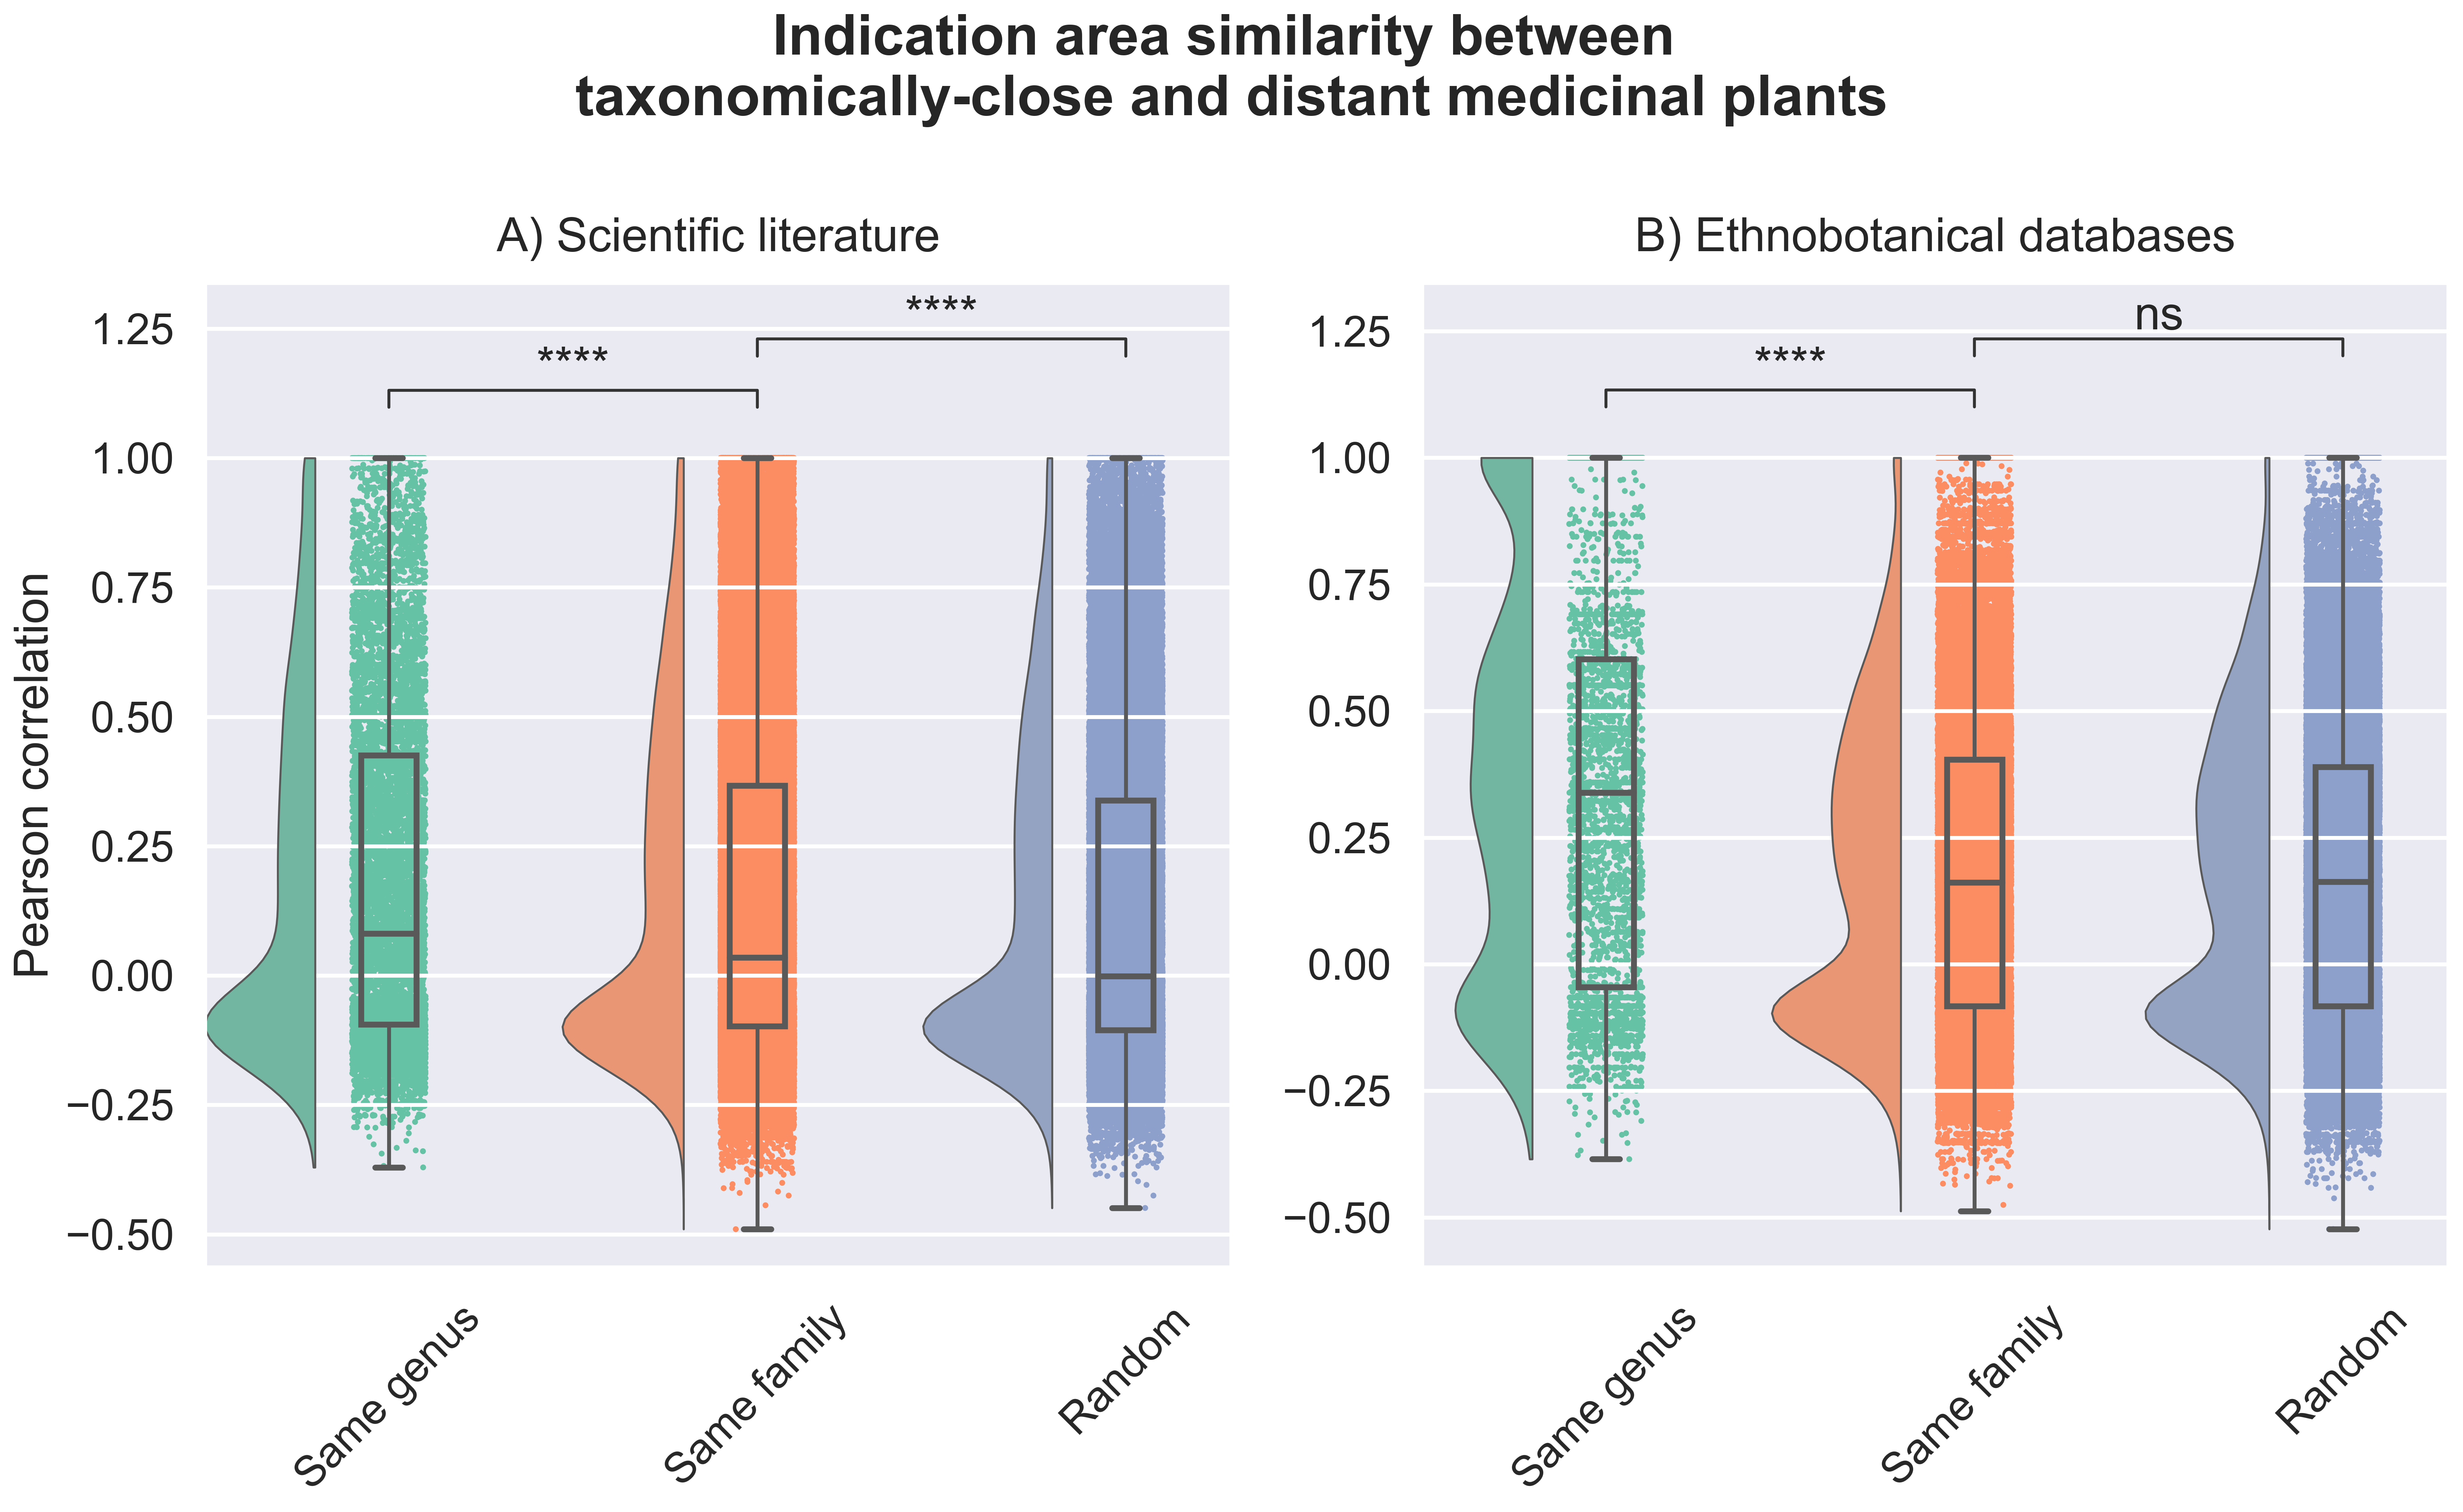

In [33]:
fig = plt.figure(figsize=(18, 11)) 

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

suptitle = plt.suptitle(
    'Indication area similarity between \ntaxonomically-close and distant medicinal plants',
    y=0.99,
    fontweight='bold',
)

pt.RainCloud(
    data=lit_merged_df,
    x='pair_type',
    y='pearson_coefficient',
    ax=ax1,
    order=['Same genus', 'Same family', 'Random'],
)
add_stat_annotation(
    data=lit_merged_df,
    x='pair_type',
    y='pearson_coefficient',
    ax=ax1,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
# ax1.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax1.set_ylabel("Pearson correlation")
ax1.set_xlabel("")
ax1.set_title("A) Scientific literature", y=1.02)

pt.RainCloud(
    data=df_merged_df,
    x='pair_type',
    y='pearson_coefficient',
    ax=ax2,
    order=['Same genus', 'Same family', 'Random'],
)
add_stat_annotation(
    data=df_merged_df,
    x='pair_type',
    y='pearson_coefficient',
    ax=ax2,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax2.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
# ax2.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax2.set_ylabel("")
ax2.set_xlabel("")

ax2.set_title("B) Ethnobotanical databases", y=1.02)
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/figure_2.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()

In [34]:
for col in lit_merged_df.pair_type.unique():
    info = lit_merged_df[lit_merged_df.pair_type == col]
    print(
        f'Disease area similarity (literature) for {col} \
        mean: {info["pearson_coefficient"].mean():.3f}, \
        median: {info["pearson_coefficient"].median():.3f} \
        sd error of the mean: {sem(info["pearson_coefficient"].tolist())} \
        '
    )

Disease area similarity (literature) for Same genus         mean: 0.185,         median: 0.081         sd error of the mean: 0.003191893026686646         
Disease area similarity (literature) for Same family         mean: 0.148,         median: 0.035         sd error of the mean: 0.0006842504721208766         
Disease area similarity (literature) for Random         mean: 0.131,         median: -0.001         sd error of the mean: 0.0009502221956585537         


In [35]:
for col in df_merged_df.pair_type.unique():
    info = df_merged_df[df_merged_df.pair_type == col]
    print(
        f'Disease area similarity (databases) for {col} \
        mean: {info["pearson_coefficient"].mean():.3f}, \
        median: {info["pearson_coefficient"].median():.3f} \
        sd error of the mean: {sem(info["pearson_coefficient"].tolist())} \
        '
    )

Disease area similarity (databases) for Same genus         mean: 0.350,         median: 0.339         sd error of the mean: 0.006458606047367311         
Disease area similarity (databases) for Same family         mean: 0.181,         median: 0.161         sd error of the mean: 0.0010205602216648557         
Disease area similarity (databases) for Random         mean: 0.176,         median: 0.163         sd error of the mean: 0.0008955163698113411         


# Cosine similarity

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.454e-15 U_stat=1.173e+09
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.052e-50 U_stat=1.057e+10
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.153e-131 U_stat=1.815e+08
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.660e-02 U_stat=4.120e+09


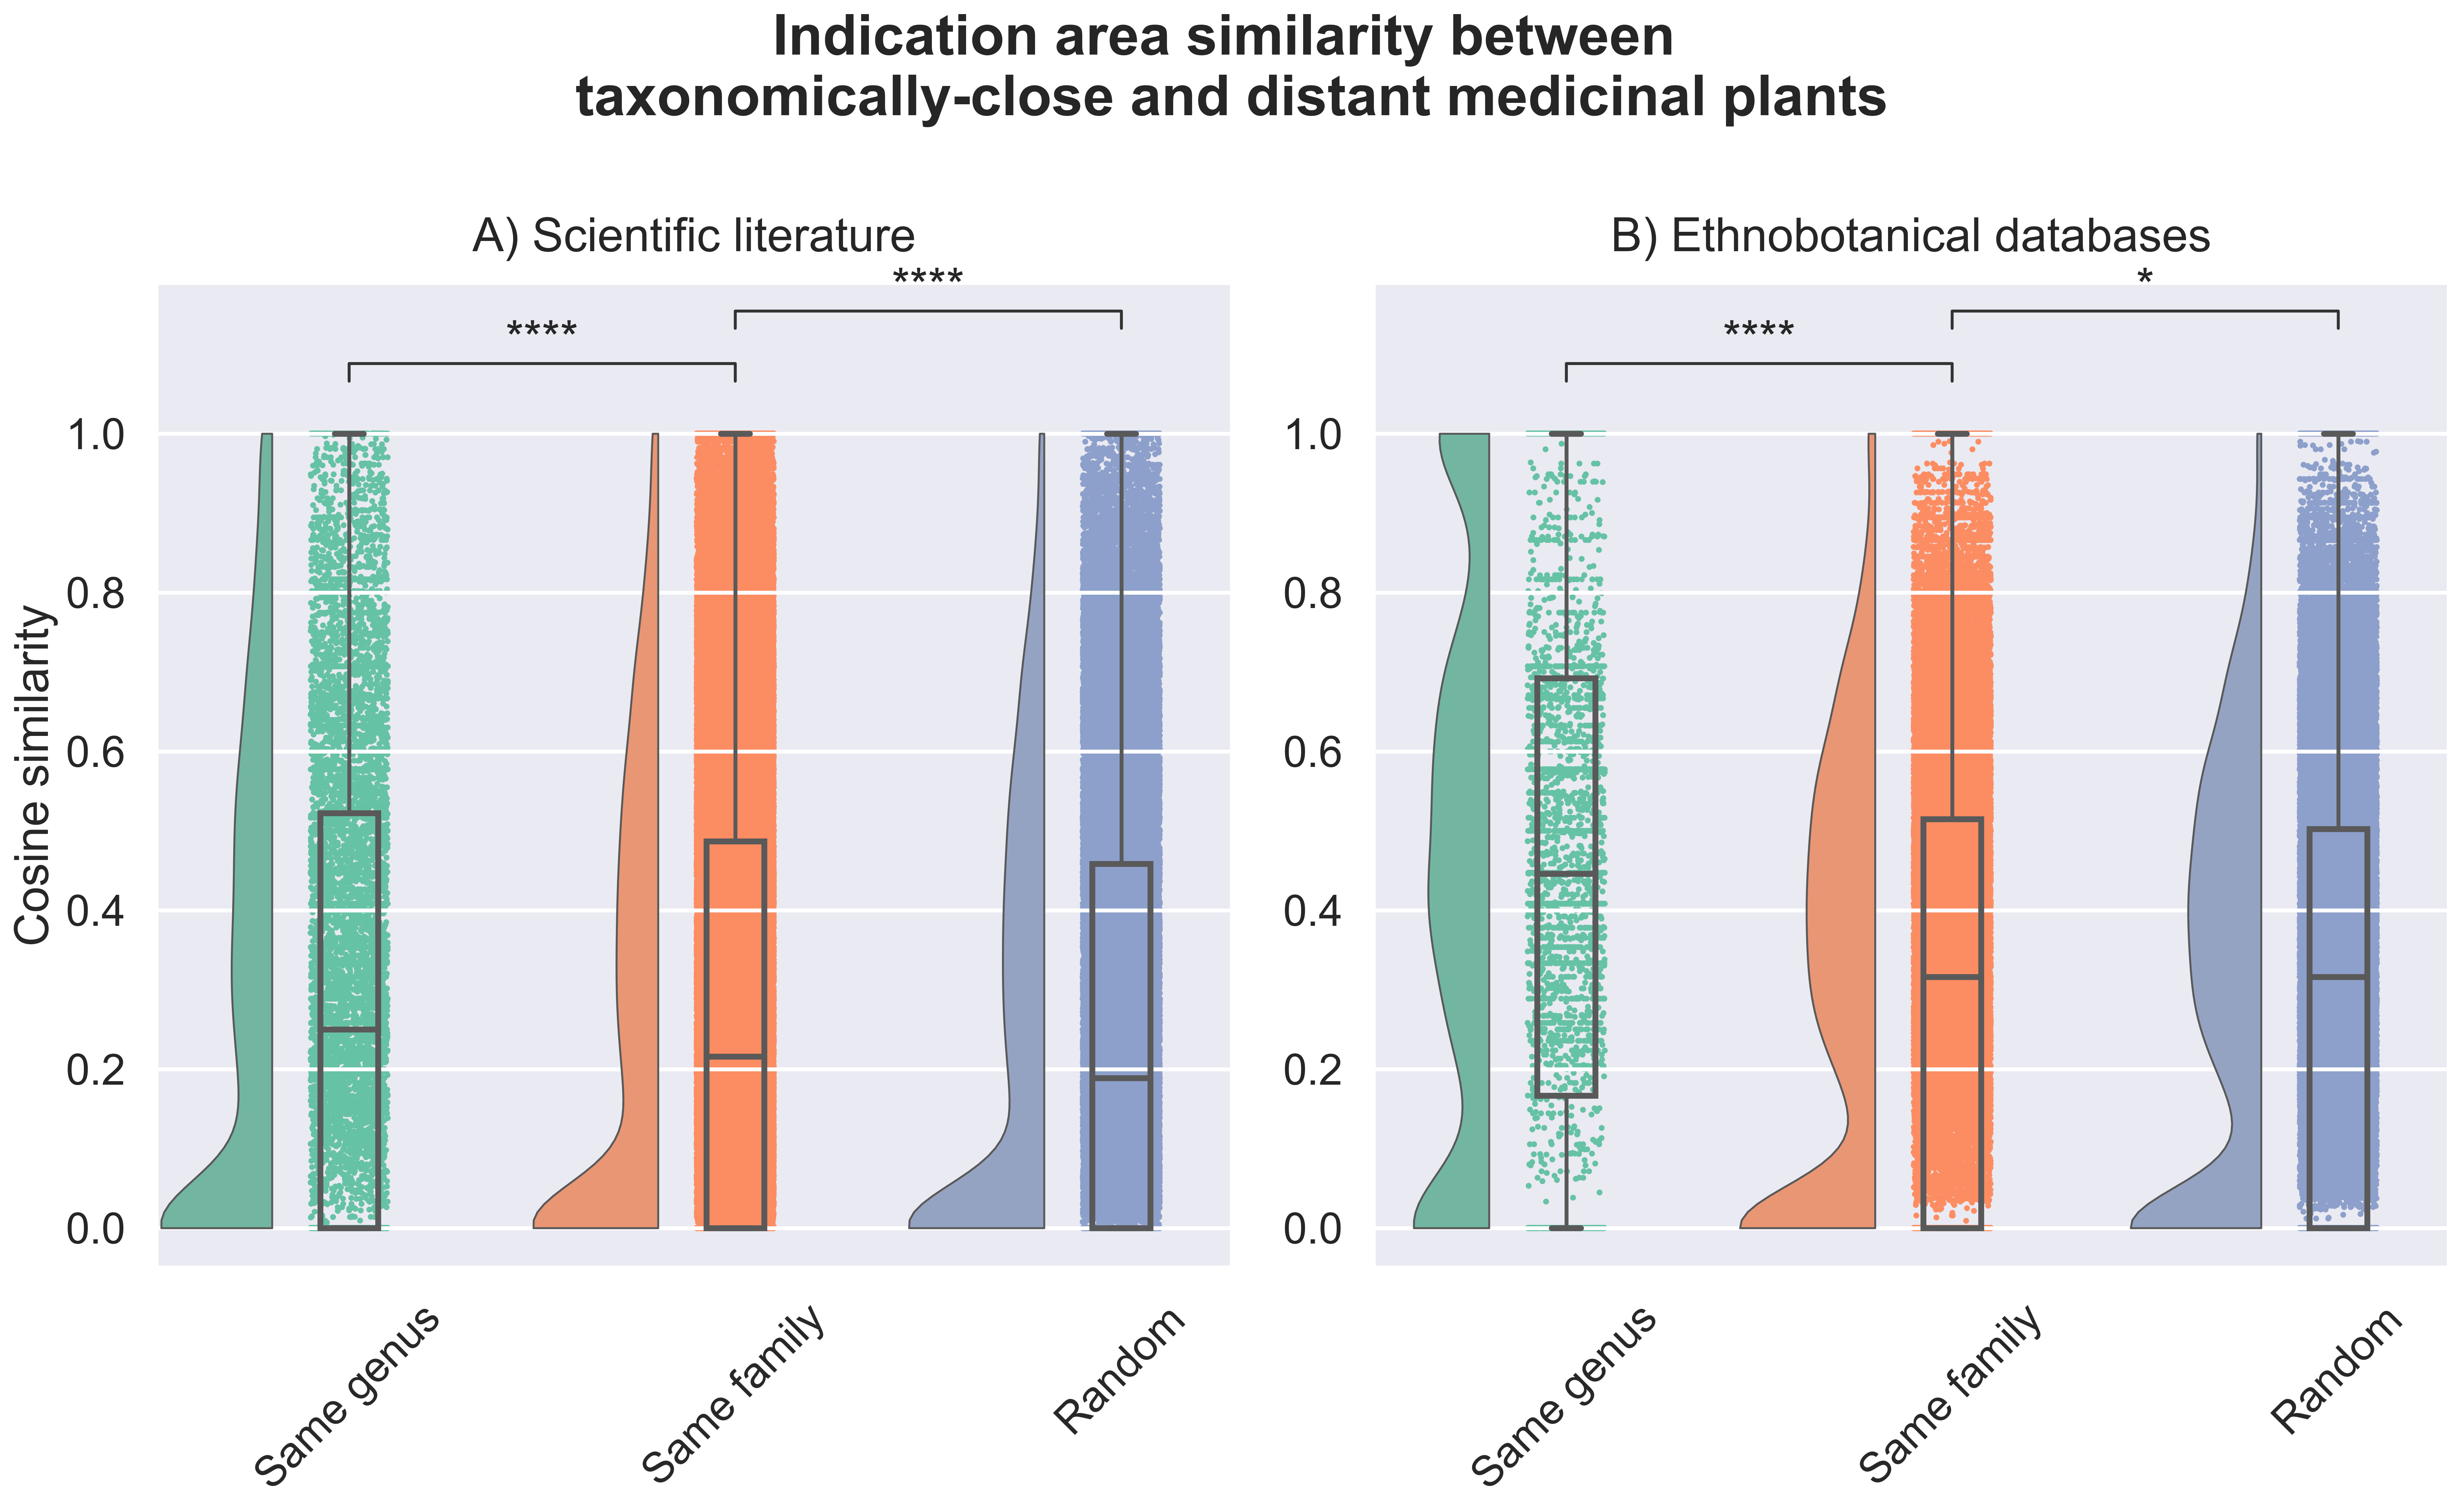

In [37]:
fig = plt.figure(figsize=(18, 11)) 

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

suptitle = plt.suptitle(
    'Indication area similarity between \ntaxonomically-close and distant medicinal plants',
    y=0.99,
    fontweight='bold',
)

pt.RainCloud(
    data=lit_merged_df,
    x='pair_type',
    y='cosine_sim',
    ax=ax1,
    order=['Same genus', 'Same family', 'Random'],
)
add_stat_annotation(
    data=lit_merged_df,
    x='pair_type',
    y='cosine_sim',
    ax=ax1,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)
ax1.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax1.set_ylabel("Cosine similarity")
ax1.set_xlabel("")
ax1.set_title("A) Scientific literature", y=1.02)

pt.RainCloud(
    data=df_merged_df,
    x='pair_type',
    y='cosine_sim',
    ax=ax2,
    order=['Same genus', 'Same family', 'Random'],
)
add_stat_annotation(
    data=df_merged_df,
    x='pair_type',
    y='cosine_sim',
    ax=ax2,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax2.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
ax2.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax2.set_ylabel("")
ax2.set_xlabel("")

ax2.set_title("B) Ethnobotanical databases", y=1.02)
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/supplementary_cosine.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()